# Part 0: Startup

In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import pytz

In [2]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install kaleido

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


# Part III Index

## proposer reward

In [6]:
import pandas as pd
reward=pd.read_csv('rewards.csv')
reward['Date']=reward['Date'].astype('datetime64[ns]')
reward.dtypes
reward.columns

Index(['Date', 'Validator_index', 'final_total_count', 'final_total_sum',
       'proposer_count', 'proposer_sum', 'attest_count', 'attest_sum',
       'sync_count', 'sync_sum', 'epoch_count'],
      dtype='object')

In [7]:
reward.head()

,Date,Validator_index,final_total_count,final_total_sum,proposer_count,proposer_sum,attest_count,attest_sum,sync_count,sync_sum,epoch_count
0,2022-09-15,0,162,2317783,0,0,162,2317783,0,0,162
1,2022-09-15,1,162,2285993,0,0,162,2285993,0,0,162
2,2022-09-15,2,162,2261322,0,0,162,2261322,0,0,162
3,2022-09-15,3,162,2314157,0,0,162,2314157,0,0,162
4,2022-09-15,4,162,2314936,0,0,162,2314936,0,0,162


In [8]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Sample data, replace with your actual data
df = reward.copy()

# Calculate the mean of proposer_count by Date
proposer_sum = df.groupby('Date')['sync_count'].sum().reset_index()

# Create a subplot layout: 2 rows and 1 column
fig = make_subplots(rows=1, cols=2, shared_xaxes=True, vertical_spacing=0.1)

# Add box plot to the top
fig.add_trace(go.Box(y=proposer_sum['sync_count'], name='Box plot of sync committee counts mean'), row=1, col=1)

# Add time series plot to the bottom
fig.add_trace(go.Scatter(x=proposer_sum['Date'], y=proposer_sum['sync_count'], mode='lines', name='sync committee counts over time'), row=1, col=2)

# Set the font to 'Courier New', title for the figure, and adjust legend position
fig.update_layout(
    font=dict(
        family="Courier New, monospace",
        size=18,
    ),
    title='Daily Mean of Sync Committee Count',
    legend=dict(
        x=0.5,
        y=1.15,
        orientation="h",
        xanchor="center"
    )
)

fig.show()

In [10]:
# Save the figure with high resolution
fig.write_image("validator_count_sync.png", width=1600, height=900, scale=3)  # The scale parameter can be adjusted for desired resolution.

In [11]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Sample data, replace with your actual data
df = reward.copy()

# Calculate the mean of Validator_index by Date
validator_means = df.groupby('Date')['sync_sum'].mean().reset_index()

# Create a subplot layout: 2 rows and 1 column
fig = make_subplots(rows=1, cols=2, shared_xaxes=True, vertical_spacing=0.1)

# Add box plot to the top
fig.add_trace(go.Box(y=validator_means['sync_sum'], name='Box plot of sync committee reward means'), row=1, col=1)

# Add time series plot to the bottom
fig.add_trace(go.Scatter(x=validator_means['Date'], y=validator_means['sync_sum'], mode='lines', name='sync committee reward means over time'), row=1, col=2)

# Set the font to 'Courier New', title for the figure, and adjust legend position
fig.update_layout(
    font=dict(
        family="Courier New, monospace",
        size=18,
    ),
    title='Daily Mean Sync Committee Reward',
    legend=dict(
        x=0.5,
        y=1.15,
        orientation="h",
        xanchor="center"
    )
)

# Update the y-axis label
fig.update_yaxes(title_text="reward (gwei)")

fig.show()


In [12]:
# Save the figure with high resolution
fig.write_image("validator_reward_mean_sync.png", width=1600, height=900, scale=3)  # The scale parameter can be adjusted for desired resolution.

In [13]:
# set the reward to calculate the index
reward_name ='sync_sum'

In [14]:
df = reward[['Date',reward_name]]
df

,Date,sync_sum
0,2022-09-15,0
1,2022-09-15,0
2,2022-09-15,0
3,2022-09-15,0
4,2022-09-15,0
...,...,...
28148852,2022-11-16,0
28148853,2022-11-16,0
28148854,2022-11-16,0
28148855,2022-11-16,0


In [15]:
data =df.copy()
data.columns =['Date','value']

In [19]:
def index(df):
    df['value'] = df['value'].astype(float)
    df['prop'] = df['value']/df['value'].sum() 
    H = -df['prop']*np.log2(df['prop'])
    E = H.sum()
    V = 2**E
    return V

def HHI(df):
    df['value'] = df['value'].astype(float)
    df['prop'] = df['value']/df['value'].sum() 
    SQ = df['prop']**2
    V = SQ.sum()
    return V

def gini(df):
    """
    Compute Gini coefficient of a DataFrame with a 'value' column
    """
    # Check if the DataFrame is empty or the 'value' column does not exist
    if df.empty or 'value' not in df.columns:
        return None 
    # Extract the 'value' column and convert it to a sorted list
    values = sorted(df['value'].tolist())
    # Check if the list is empty
    if len(values) == 0:
        return None
    # Compute the cumulative sum of the values
    cum_values = [0] + list(pd.Series(values).cumsum())
    n = len(values)
    # Calculate Gini coefficient using the formula
    numer = sum([(i+1) * values[i] for i in range(n)])
    denom = n * sum(values)
    if denom == 0:
        return None  # Avoid division by zero
    gini = (2 * numer) / denom - (n + 1) / n
    return gini

def nakamoto(df):
    df['value'] = df['value'].astype(float)
    df.sort_values(by=['value'],ascending=False,inplace=True)
    df.reset_index(inplace=True,drop=True)
    df.set_index(keys=df.index.values+1,inplace=True)
    df['prop'] = df['value']/df['value'].sum() 
    df['cumprop'] = df['prop'].cumsum(axis=0)
    try:
        V = df[df['cumprop'] > 0.5].index[0]
        return V
    except:
        return 0


In [16]:
from datetime import date
start = date(2022,9,15)
end = date(2022,11,15)

In [20]:
"""
def index_calc(data):

            :param data: dataframe containing transaction value and timestamp of the transaction (block_timestamp)
            :type data: pandas.DataFrame object
            :param start: the start date of calculation 00:00:00 UTC
            :type start: datetime.date object
            :param end: the end date of calculation 23:59:59 UTC
            :type end: datetime.date object
            :param index_type: the metrics used for measuring decentralization, default is our index
            :type index_type: index function

    returns pandas dataframe with decentralization index value and date
"""
from tqdm import tqdm
def index_calc(data,  start, end, index_type = index):
    duration= pd.date_range(start=start, end=end)
    days = np.size(duration)
    IndexValues = pd.DataFrame(np.zeros(days), columns=['val'])
    IndexValues['date'] = duration

    for i in tqdm(range(0, days)):
        start_date = start + timedelta(days=i)
        end_date = start_date + timedelta(days=1)
        IndexValues.loc[i,'val'] = index_type(data[(data['Date'].dt.date >= start_date) & (data['Date'].dt.date < end_date)].copy())
    
    return IndexValues
    

In [21]:
#input transaction data and desired date range
#returns index value 1 if specification range exceeds data 
start = date(2022,9,15)
end = date(2022,11,15)
results = index_calc(data,start,end)

  0%|          | 0/62 [00:00<?, ?it/s]/Users/sunshinela/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log2

/Users/sunshinela/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log2

  2%|▏         | 1/62 [00:09<09:22,  9.23s/it]/Users/sunshinela/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log2

/Users/sunshinela/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log2

  3%|▎         | 2/62 [00:18<09:04,  9.07s/it]/Users/sunshinela/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log2

/Users/sunshinela/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log2

  5

In [22]:
results

,val,date
0,1059.848476,2022-09-15
1,971.685773,2022-09-16
2,784.706773,2022-09-17
3,523.493236,2022-09-18
4,535.165215,2022-09-19
...,...,...
57,1041.588224,2022-11-11
58,1007.928131,2022-11-12
59,933.816061,2022-11-13
60,754.096526,2022-11-14


In [23]:
results.to_csv('ShannonIndex_sync.csv',index=False)

In [24]:
#specify alternate index metric: HHI
#returns index value 0 if specification range exceeds data
start = date(2022,9,15)
end = date(2022,11,15)
results_HHI = index_calc(data,start,end,HHI)
results_HHI.to_csv('HHI_Index_sync.csv',index=False)

100%|██████████| 62/62 [08:53<00:00,  8.60s/it]


In [25]:
results_HHI

,val,date
0,0.001080,2022-09-15
1,0.001242,2022-09-16
2,0.001534,2022-09-17
3,0.002017,2022-09-18
4,0.002059,2022-09-19
...,...,...
57,0.001009,2022-11-11
58,0.001043,2022-11-12
59,0.001267,2022-11-13
60,0.001629,2022-11-14


In [26]:
#specify alternate index metric: gini
#returns index value 0 if specification range exceeds data
start = date(2022,9,15)
end = date(2022,11,15)
results_Gini = index_calc(data,start,end,gini)
results_Gini.to_csv('Gini_Index_sync.csv',index=False)

100%|██████████| 62/62 [08:59<00:00,  8.71s/it]


In [27]:
results_Gini

,val,date
0,1.024228,2022-09-15
1,1.022132,2022-09-16
2,1.010958,2022-09-17
3,1.011511,2022-09-18
4,1.022149,2022-09-19
...,...,...
57,1.008456,2022-11-11
58,1.003847,2022-11-12
59,1.015664,2022-11-13
60,1.016093,2022-11-14


In [28]:
#specify alternate index metric: nakamoto coefficient
#returns index value 0 if specification range exceeds data
start = date(2022,9,15)
end = date(2022,11,15)
results_nakamoto = index_calc(data,start,end,nakamoto)
results_nakamoto.to_csv("results_nakamoto_sync.csv")

100%|██████████| 62/62 [09:03<00:00,  8.77s/it]


In [29]:
results_nakamoto

,val,date
0,412.0,2022-09-15
1,334.0,2022-09-16
2,285.0,2022-09-17
3,246.0,2022-09-18
4,244.0,2022-09-19
...,...,...
57,475.0,2022-11-11
58,408.0,2022-11-12
59,330.0,2022-11-13
60,276.0,2022-11-14


In [31]:
# Merge all the dataframes together
import pandas as pd

# Assuming the dataframes results, results_HHI, results_Gini, and results_nakamoto are already defined...

# Rename 'val' columns for each dataframe first
results = results.rename(columns={'val': 'ShannonEntropy'})
results_HHI = results_HHI.rename(columns={'val': 'HHI'})
results_Gini = results_Gini.rename(columns={'val': 'Gini'})  # There was a small inconsistency here, I assumed you want to rename this column 'Gini'
results_nakamoto = results_nakamoto.rename(columns={'val': 'Nakamoto'})

# Now, merge the dataframes on the 'Date' column
merged_df = results.merge(results_HHI, on='date', how='outer') \
    .merge(results_Gini, on='date', how='outer') \
    .merge(results_nakamoto, on='date', how='outer')

print(merged_df)
merged_df.columns

    ShannonEntropy       date       HHI      Gini  Nakamoto
0      1059.848476 2022-09-15  0.001080  1.024228     412.0
1       971.685773 2022-09-16  0.001242  1.022132     334.0
2       784.706773 2022-09-17  0.001534  1.010958     285.0
3       523.493236 2022-09-18  0.002017  1.011511     246.0
4       535.165215 2022-09-19  0.002059  1.022149     244.0
..             ...        ...       ...       ...       ...
57     1041.588224 2022-11-11  0.001009  1.008456     475.0
58     1007.928131 2022-11-12  0.001043  1.003847     408.0
59      933.816061 2022-11-13  0.001267  1.015664     330.0
60      754.096526 2022-11-14  0.001629  1.016093     276.0
61      518.292409 2022-11-15  0.001997  1.006938     247.0

[62 rows x 5 columns]


Index(['ShannonEntropy', 'date', 'HHI', 'Gini', 'Nakamoto'], dtype='object')

In [32]:
# Reorder the columns
merged_df = merged_df[['date', 'ShannonEntropy', 'HHI', 'Gini', 'Nakamoto']]
Index4=merged_df
Index4.to_csv("Index4_sync.csv")
Index4

,date,ShannonEntropy,HHI,Gini,Nakamoto
0,2022-09-15,1059.848476,0.001080,1.024228,412.0
1,2022-09-16,971.685773,0.001242,1.022132,334.0
2,2022-09-17,784.706773,0.001534,1.010958,285.0
3,2022-09-18,523.493236,0.002017,1.011511,246.0
4,2022-09-19,535.165215,0.002059,1.022149,244.0
...,...,...,...,...,...
57,2022-11-11,1041.588224,0.001009,1.008456,475.0
58,2022-11-12,1007.928131,0.001043,1.003847,408.0
59,2022-11-13,933.816061,0.001267,1.015664,330.0
60,2022-11-14,754.096526,0.001629,1.016093,276.0


In [33]:
Index4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            62 non-null     datetime64[ns]
 1   ShannonEntropy  62 non-null     float64       
 2   HHI             62 non-null     float64       
 3   Gini            62 non-null     float64       
 4   Nakamoto        62 non-null     float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 2.9 KB


In [34]:
Index4.describe()

,ShannonEntropy,HHI,Gini,Nakamoto
count,62.000000,62.000000,62.000000,62.000000
mean,830.596446,0.001424,1.009190,331.177419
std,186.712463,0.000360,0.005830,73.611858
min,510.568832,0.000995,1.000267,243.000000
25%,666.166711,0.001085,1.004622,266.500000
50%,881.289750,0.001337,1.008209,314.000000
75%,1005.640307,0.001739,1.012397,383.000000
max,1059.848476,0.002072,1.025571,492.000000


In [35]:
data= pd.read_csv('Index4_sync.csv')

In [36]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Sample dataframe (replace with your actual dataframe)
df = data.copy()

# Create a 2x2 subplot layout
fig = make_subplots(rows=2, cols=2, subplot_titles=('ShannonEntropy', 'HHI', 'Gini', 'Nakamoto'))
# Add box plots to each subplot
fig.add_trace(go.Box(y=df['ShannonEntropy'], name='ShannonEntropy'), row=1, col=1)
fig.add_trace(go.Box(y=df['HHI'], name='HHI'), row=1, col=2)
fig.add_trace(go.Box(y=df['Gini'], name='Gini'), row=2, col=1)
fig.add_trace(go.Box(y=df['Nakamoto'], name='Nakamoto'), row=2, col=2)

# Explanation with LaTeX
#explanation = r'Note: In this plot, the symbol $\mu$ represents a factor of $10^{-6}$.'

# Update layout for better aesthetics and add explanation
fig.update_layout(
    title='Boxplots of Metrics: Sync Committee Rewards',
    showlegend=True,
    font=dict(family="Courier New, monospace")
)

fig.show()


In [37]:
# Save the figure with high resolution
fig.write_image("index_boxplot_sync.png", height=900, width=1600, scale=2)  # The scale parameter can be adjusted for desired resolution.

In [38]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Sample dataframe (replace with your actual dataframe)
df = data.copy()

# Create a 4x1 subplot layout
fig = make_subplots(rows=4, cols=1, shared_xaxes=False, subplot_titles=('ShannonEntropy', 'HHI', 'Gini', 'Nakamoto'))

# Add traces for each metric
fig.add_trace(go.Scatter(x=df['date'], y=df['ShannonEntropy'], mode='lines', name='ShannonEntropy'), row=1, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['HHI'], mode='lines', name='HHI'), row=2, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['Gini'], mode='lines', name='Gini'), row=3, col=1)
fig.add_trace(go.Scatter(x=df['date'], y=df['Nakamoto'], mode='lines', name='Nakamoto'), row=4, col=1)

# LaTeX styled title and subplot titles
fig.update_layout(
    title_text="Time Series of Metrics: Sync Committee Rewards",
    font=dict(family="Courier New, monospace", size=16, color="#7f7f7f"),
    height=1000,  # Adjusted height
    template="plotly"  # Set the theme to ggplot2
)

# Add LaTeX explanation
# Explanation with LaTeX-style formatting
#explanation = "Note: In this plot, the symbol $\\mu$ represents the metric prefix 'micro-', denoting a factor of $10^{-6}$."

# Show the plot
fig.show()


In [39]:
# Save the figure with high resolution
fig.write_image("index_timeseries_sync.png", height=900, width=1600, scale=2)  # The scale parameter can be adjusted for desired resolution.

In [40]:
import pandas as pd
from scipy.stats import shapiro, anderson

# Sample dataframe (replace with your actual dataframe)
df = data.copy()

# Shapiro-Wilk Test
def shapiro_test(data):
    stat, p = shapiro(data)
    print(f'Shapiro-Wilk Test:\nStatistic={stat:.5f}, p={p:.5f}')
    if p > 0.05:
        print('Sample looks Gaussian (fail to reject H0)\n')
    else:
        print('Sample does not look Gaussian (reject H0)\n')

# Anderson-Darling Test
def anderson_test(data):
    result = anderson(data)
    print('Anderson-Darling Test:')
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < cv:
            print(f'At significance level {sl:.2f}, data looks normal (fail to reject H0)')
        else:
            print(f'At significance level {sl:.2f}, data does not look normal (reject H0)')
    print()

columns = ['ShannonEntropy', 'HHI', 'Gini', 'Nakamoto']

for col in columns:
    print(f"Testing for variable: {col}")
    shapiro_test(df[col])
    anderson_test(df[col])


Testing for variable: ShannonEntropy
Shapiro-Wilk Test:
Statistic=0.88309, p=0.00003
Sample does not look Gaussian (reject H0)

Anderson-Darling Test:
At significance level 15.00, data does not look normal (reject H0)
At significance level 10.00, data does not look normal (reject H0)
At significance level 5.00, data does not look normal (reject H0)
At significance level 2.50, data does not look normal (reject H0)
At significance level 1.00, data does not look normal (reject H0)

Testing for variable: HHI
Shapiro-Wilk Test:
Statistic=0.89191, p=0.00005
Sample does not look Gaussian (reject H0)

Anderson-Darling Test:
At significance level 15.00, data does not look normal (reject H0)
At significance level 10.00, data does not look normal (reject H0)
At significance level 5.00, data does not look normal (reject H0)
At significance level 2.50, data does not look normal (reject H0)
At significance level 1.00, data does not look normal (reject H0)

Testing for variable: Gini
Shapiro-Wilk Tes

In [41]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def test_stationarity(df, columns):
    for column in columns:
        print(f"\nTesting stationarity for column: {column}")
        
        # Perform ADF test
        result = adfuller(df[column])
        
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        print('Critical Values:', result[4])
        
        # Interpretation based on p-value
        if result[1] <= 0.05:
            print(f"The series {column} is likely stationary.")
        else:
            print(f"The series {column} is likely non-stationary.")

# Given your dataframe name is 'df'
columns_to_test = ["ShannonEntropy", "HHI", "Gini", "Nakamoto"]
test_stationarity(df, columns_to_test)



Testing stationarity for column: ShannonEntropy
ADF Statistic: -1.5116167028889511
p-value: 0.5277570951965092
Critical Values: {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}
The series ShannonEntropy is likely non-stationary.

Testing stationarity for column: HHI
ADF Statistic: -3.000653099918426
p-value: 0.03483345395797845
Critical Values: {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}
The series HHI is likely stationary.

Testing stationarity for column: Gini
ADF Statistic: -6.085769569890318
p-value: 1.0653490624243368e-07
Critical Values: {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}
The series Gini is likely stationary.

Testing stationarity for column: Nakamoto
ADF Statistic: -2.776356311936825
p-value: 0.061731275406960454
Critical Values: {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}
The series Nakamoto is likely non-stationary.


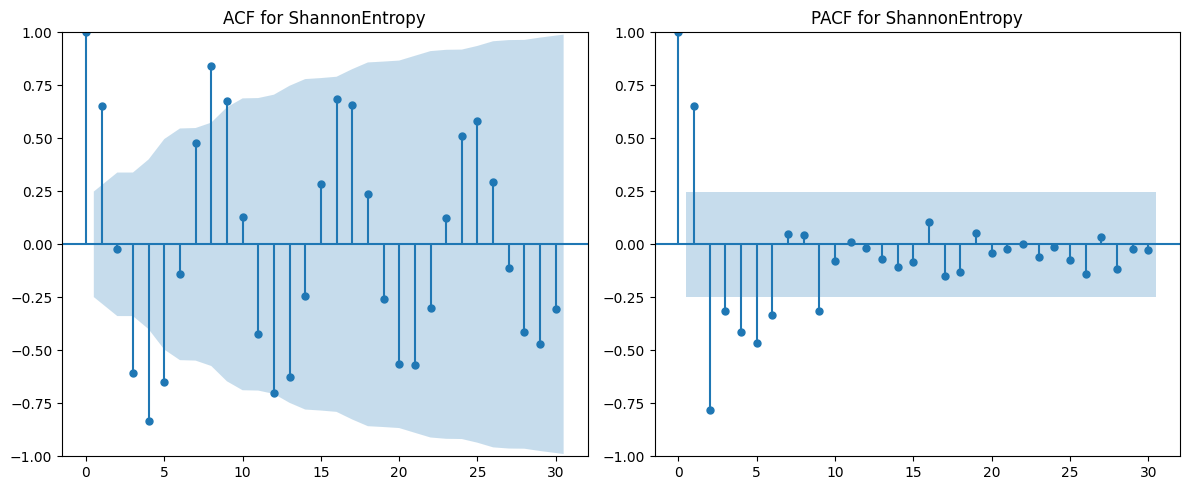

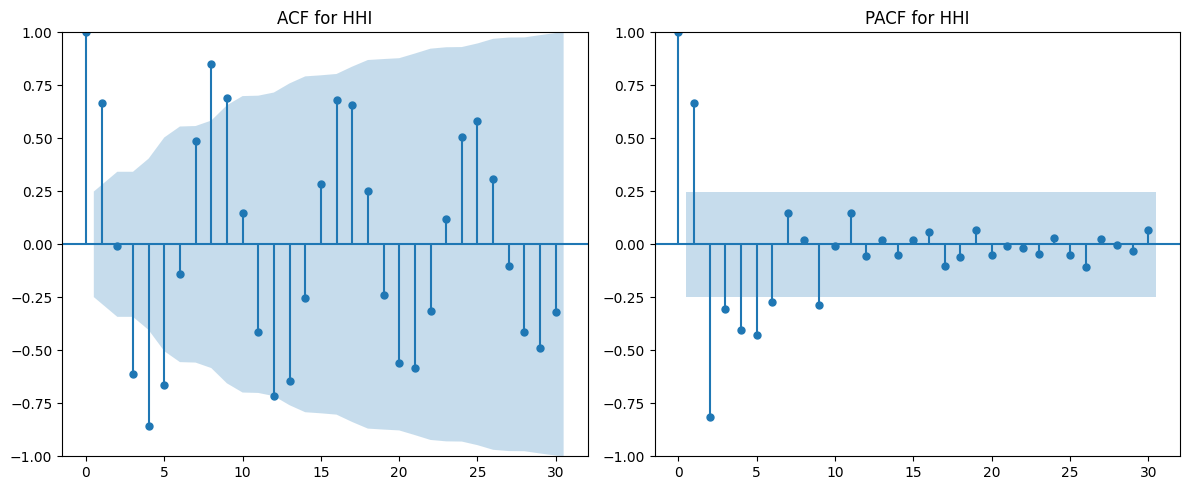

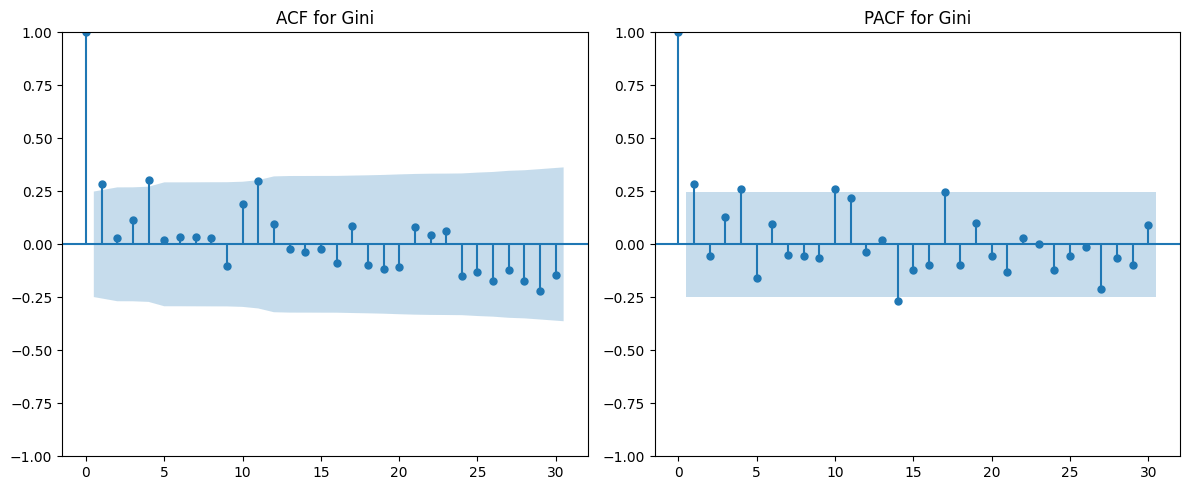

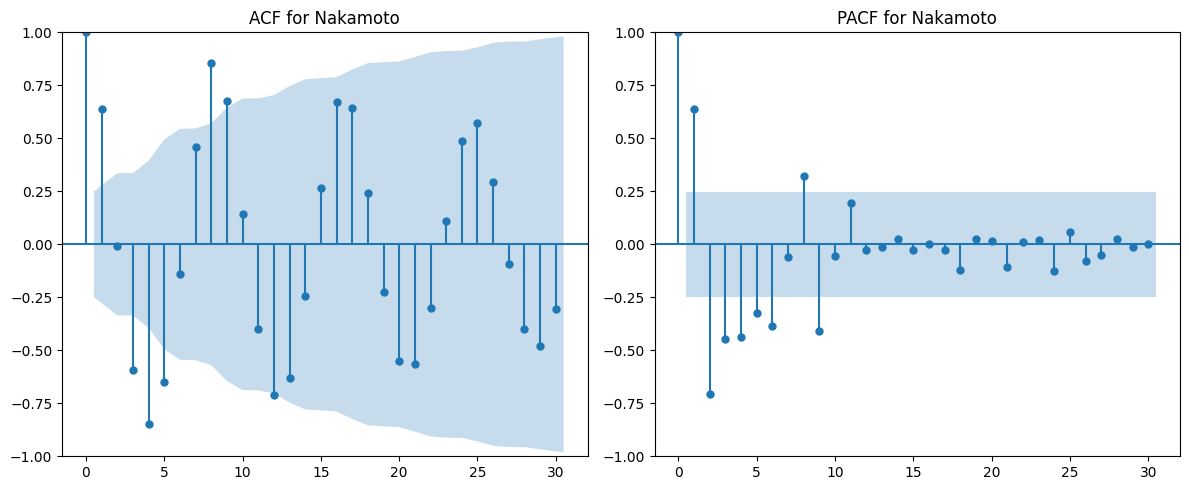

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df=data.copy()
def plot_autocorrelation(df, column_name):
    plt.figure(figsize=(12, 5))
    
    max_lags = len(df) // 2 - 1  # Ensure lags are less than half the sample size
    
    # ACF plot
    plt.subplot(1, 2, 1)
    plot_acf(df[column_name], lags=max_lags, ax=plt.gca())
    plt.title(f'ACF for {column_name}')
    
    # PACF plot
    plt.subplot(1, 2, 2)
    plot_pacf(df[column_name], lags=max_lags, ax=plt.gca())
    plt.title(f'PACF for {column_name}')
    
    plt.tight_layout()

# Save the figure with high resolution
    filename = f"{column_name}_autocorrelation.png"
    plt.savefig(filename, dpi=1800)  # You can adjust the DPI value for desired resolution.
    plt.show()

# For each of your columns
columns_to_test = ["ShannonEntropy", "HHI", "Gini", "Nakamoto"]
for column in columns_to_test:
    plot_autocorrelation(df, column)


> ACF Plot: The autocorrelation function plot gives you the correlation of the series with itself, lagged by x time units. So the y-axis is the correlation and the x-axis is the number of time units of lag.

> PACF Plot: The partial autocorrelation function plot gives the correlation of the series with itself, lagged by x time units, but with the relationships at shorter lags removed.

**Interpreting these plots**:

> Sudden Drop-Off: If either the ACF or PACF shows a sudden drop-off after a certain number of lags, this might indicate that this is the order of the autoregressive term.

> Gradual Decline: If the ACF shows a gradual decline and PACF shows a sudden drop-off, this might indicate that this is the order of the moving average term.

> Significant Spikes: If there are significant spikes at specific lags, this can indicate seasonality in the data.

By analyzing the ACF and PACF plots, you can get insights about potential patterns in your data and inform your choices when building time series models.

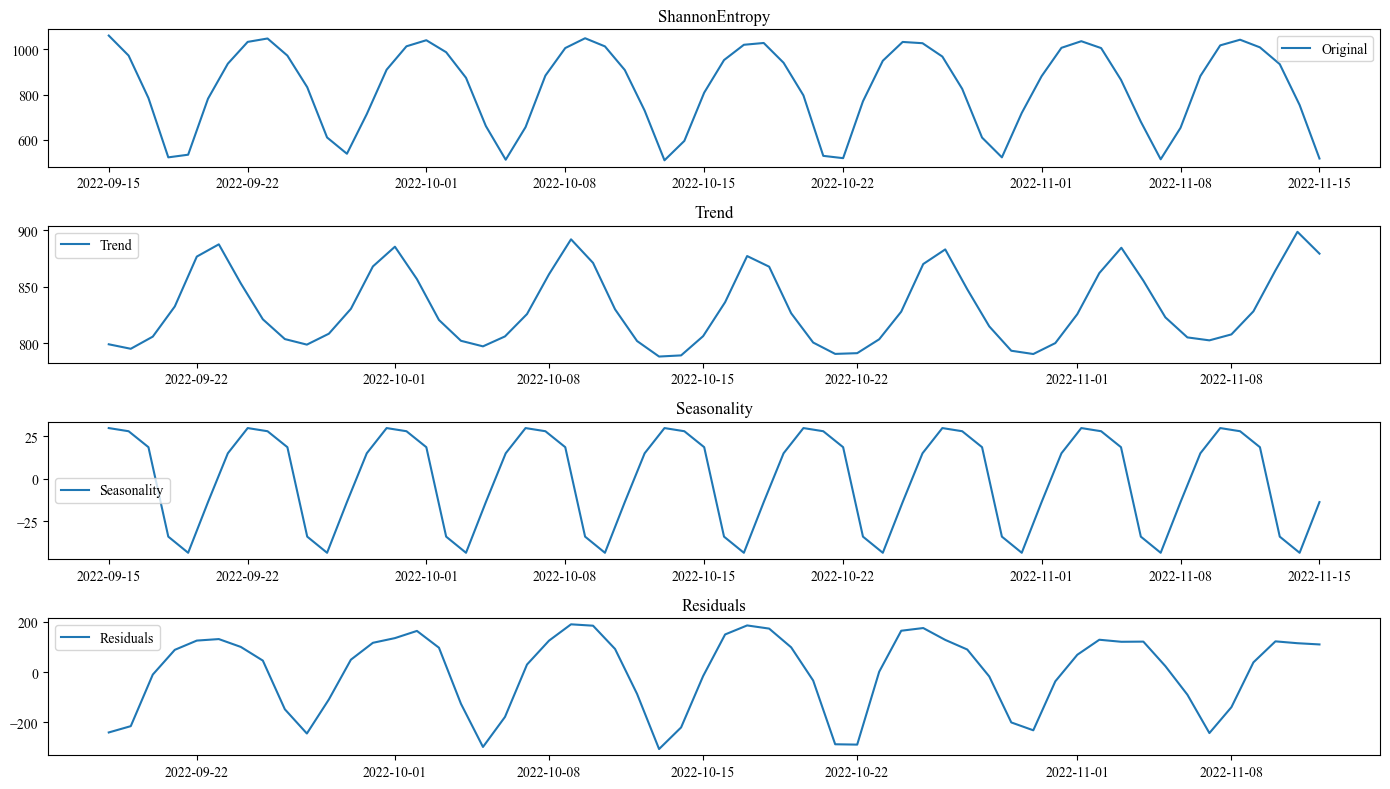

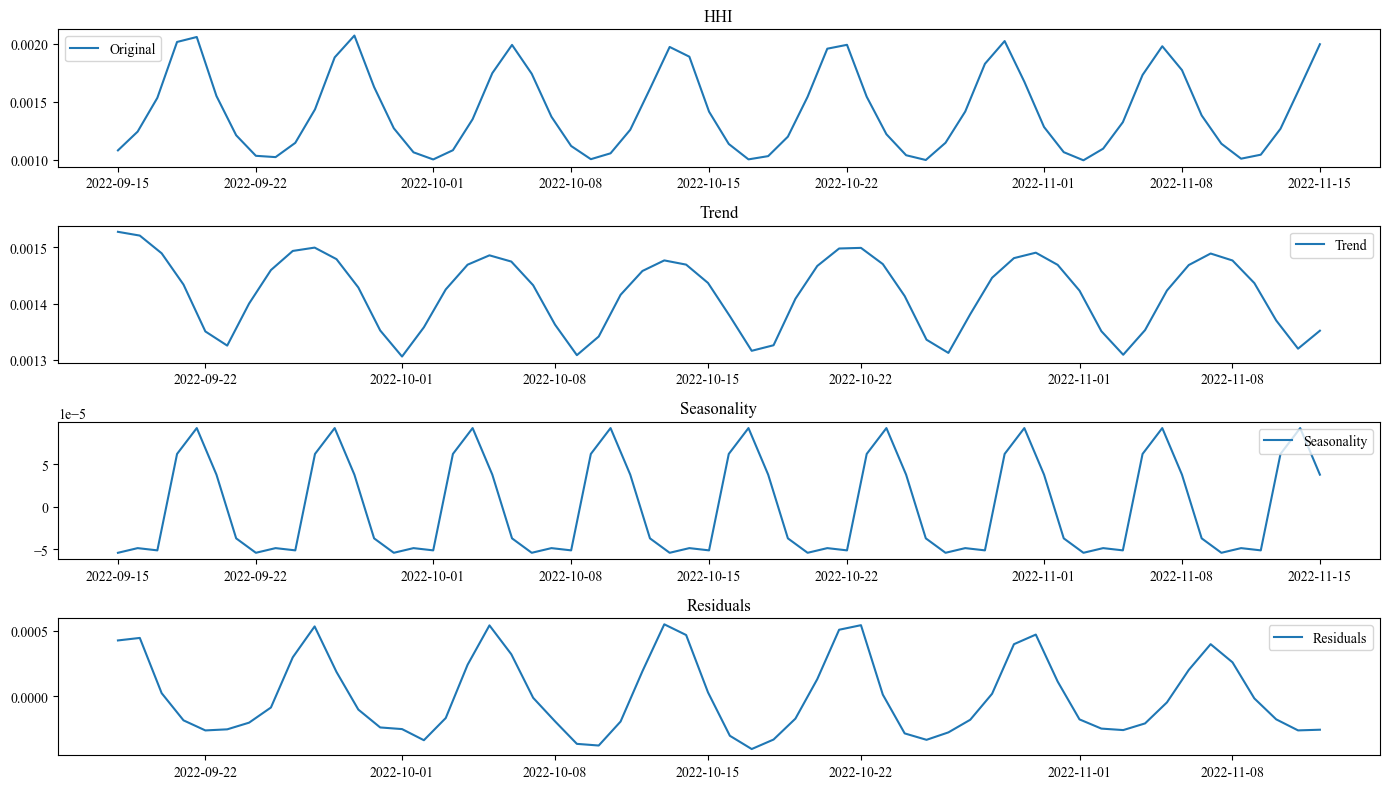

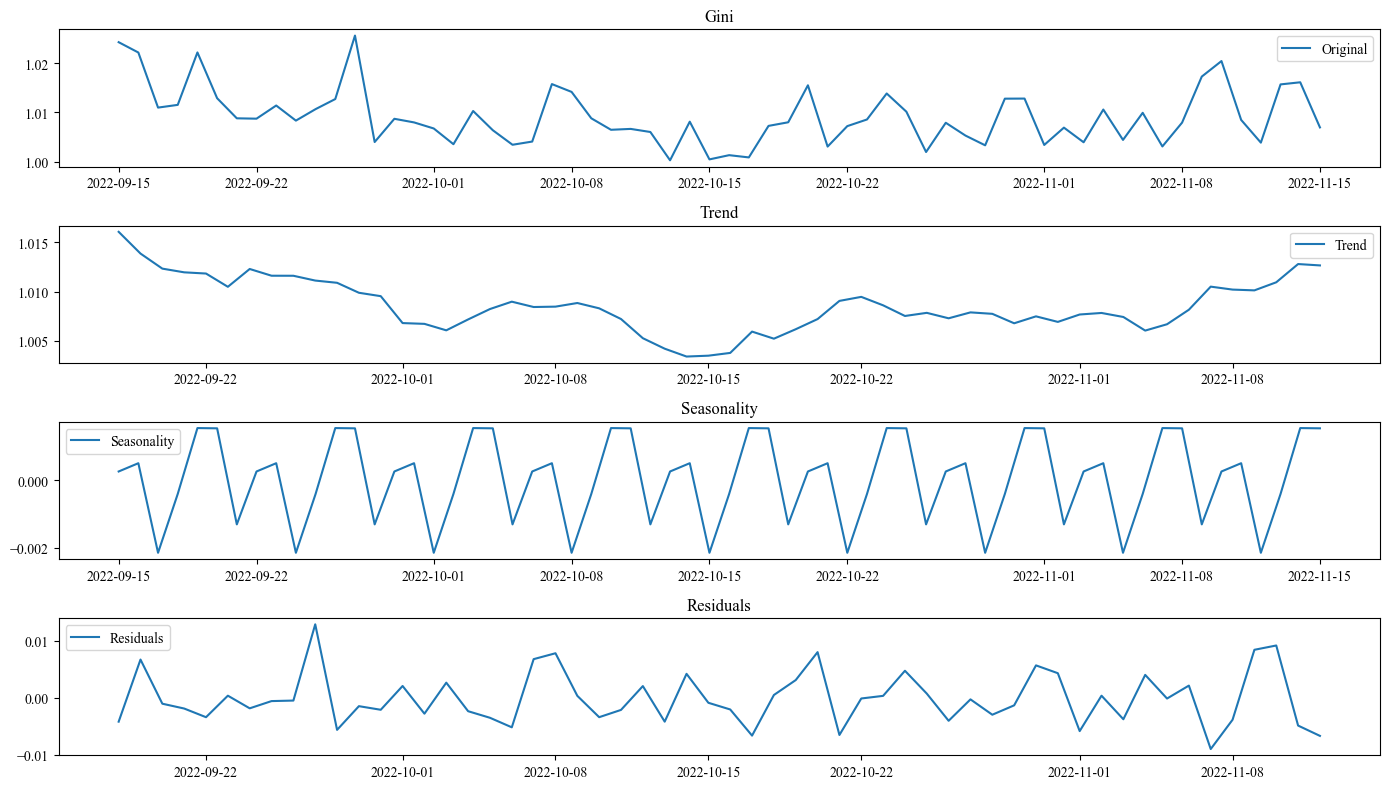

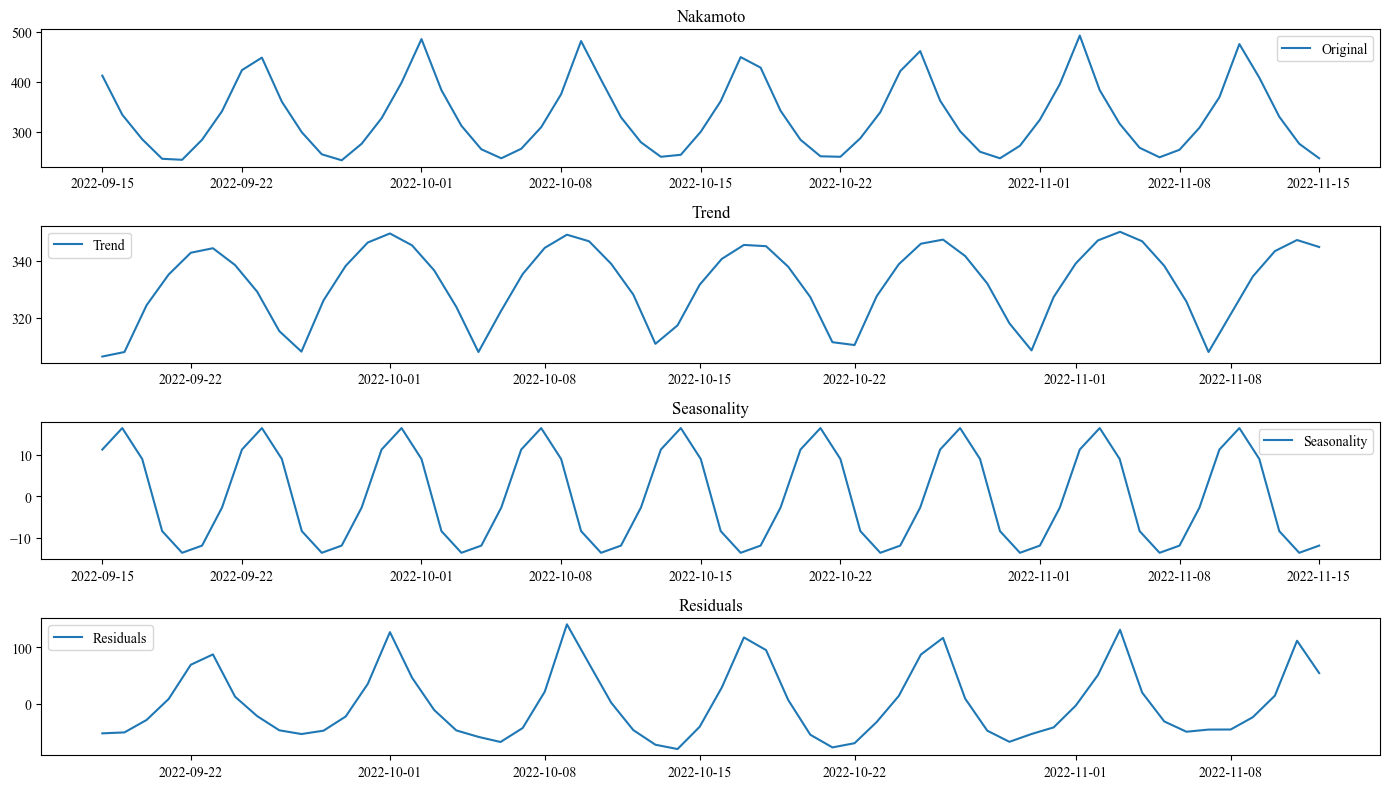

In [43]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd

# Assuming 'data' is your DataFrame
df = data.copy()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Ensure consistent frequency
if pd.infer_freq(df.index) is not None:
    df = df.asfreq(pd.infer_freq(df.index))
else:
    raise ValueError("Data frequency can't be inferred. Ensure your data has consistent frequency or manually set it.")

# Adjust matplotlib settings
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Define a function to decompose and plot
def plot_decomposition(df, column_name, period=None):
    decomposition = seasonal_decompose(df[column_name], period=period, model='additive')
    
    plt.figure(figsize=(14, 8))
    
    # Original
    plt.subplot(4, 1, 1)
    plt.plot(df[column_name], label='Original')
    plt.legend(loc='best')
    plt.title(column_name)
    
    # Trend
    plt.subplot(4, 1, 2)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='best')
    plt.title("Trend")

    # Seasonal
    plt.subplot(4, 1, 3)
    plt.plot(decomposition.seasonal, label='Seasonality')
    plt.legend(loc='best')
    plt.title("Seasonality")

    # Residuals
    plt.subplot(4, 1, 4)
    plt.plot(decomposition.resid, label='Residuals')
    plt.legend(loc='best')
    plt.title("Residuals")
    
    plt.tight_layout()
    
    # Save the figure to PNG
    plt.savefig(f'{column_name}_decomposition.png', dpi=900)
    plt.show()

# Decompose
# Provided code to set date as index, infer frequency, and plot
columns_to_decompose = ["ShannonEntropy", "HHI", "Gini", "Nakamoto"]
for column in columns_to_decompose:
    plot_decomposition(df, column)


In [44]:
import numpy as np

def detect_seasonality_frequency(ts):
    # Compute the FFT and power spectrum
    fft_vals = np.fft.fft(ts.fillna(0))
    fft_freq = np.fft.fftfreq(len(ts))
    
    # Remove the negative frequencies
    fft_vals = fft_vals[fft_freq > 0]
    fft_freq = fft_freq[fft_freq > 0]
    
    # Find the frequency with the maximum power (excluding the zero frequency)
    dominant_frequency = fft_freq[np.argmax(np.abs(fft_vals)[1:]) + 1]
    
    # Convert frequency to period (seasonality)
    seasonality = int(np.round(1 / dominant_frequency))
    return seasonality

for column in columns_to_decompose:
    seasonality = detect_seasonality_frequency(df[column].dropna())
    print(f"Detected seasonality for {column}: {seasonality} time units")


Detected seasonality for ShannonEntropy: 8 time units
Detected seasonality for HHI: 8 time units
Detected seasonality for Gini: 3 time units
Detected seasonality for Nakamoto: 8 time units


In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import numpy as np

def estimate_growth_rate(df, column_name):
    # Decompose the time series
    decomposition = seasonal_decompose(df[column_name], model='additive')
    
    # Extract trend component
    trend = decomposition.trend.dropna()
    
    # Create a time variable, t
    t = np.arange(len(trend)).reshape(-1, 1)
    
    # Fit linear regression model
    model = LinearRegression().fit(t, trend)
    
    # Return the slope as the growth rate
    return model.coef_[0]

for column in columns_to_decompose:
    growth_rate = estimate_growth_rate(df, column)
    print(f"Estimated growth rate for {column}: {growth_rate:.4f} per time unit")


Estimated growth rate for ShannonEntropy: 0.1871 per time unit
Estimated growth rate for HHI: -0.0000 per time unit
Estimated growth rate for Gini: -0.0000 per time unit
Estimated growth rate for Nakamoto: 0.1371 per time unit


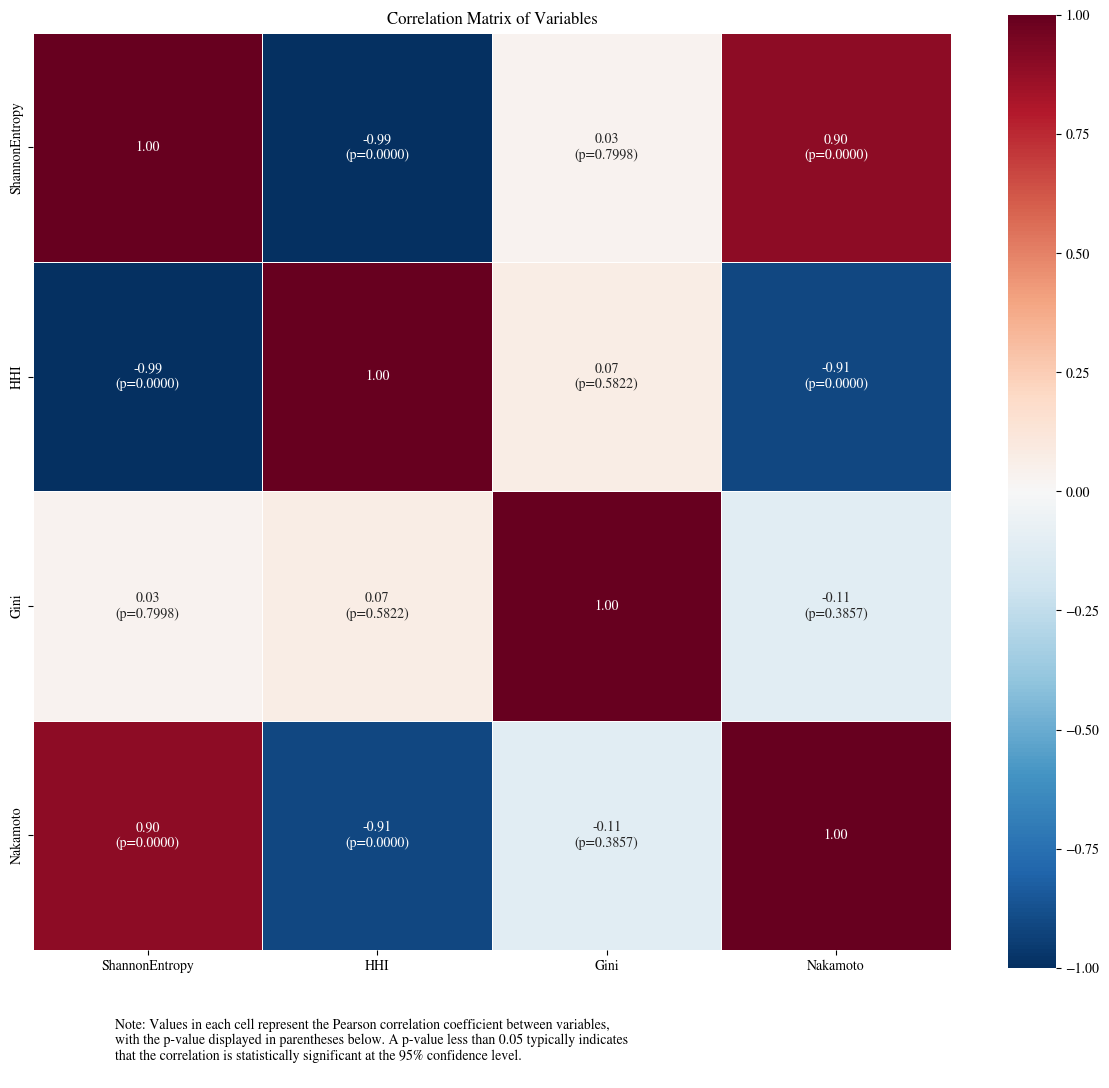

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

df = data.copy()
# Ensure LaTeX is disabled
plt.rcParams['text.usetex'] = False

# Use the 'STIX' fonts for a LaTeX-like appearance without requiring LaTeX
plt.rcParams['font.family'] = 'STIXGeneral'

# Compute the correlation matrix
corr_matrix = df[columns_to_decompose].corr()

# Compute the matrix of p-values
p_matrix = df[columns_to_decompose].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*corr_matrix.shape)

# Create an array to hold the annotations
annotations = corr_matrix.copy()
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        if i != j:
            annotations.iloc[i, j] = f'{corr_matrix.iloc[i, j]:.2f}\n(p={p_matrix.iloc[i, j]:.4f})'
        else:
            annotations.iloc[i, j] = f'{corr_matrix.iloc[i, j]:.2f}'

# Plot the heatmap with the "RdBu_r" colormap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=annotations, cmap="RdBu_r", vmin=-1, vmax=1, square=True, linewidths=.5, fmt='')
plt.title('Correlation Matrix of Variables')

# Add a figure note
figure_note = """
Note: Values in each cell represent the Pearson correlation coefficient between variables, 
with the p-value displayed in parentheses below. A p-value less than 0.05 typically indicates 
that the correlation is statistically significant at the 95% confidence level.
"""
plt.figtext(0.1, -0.01, figure_note, ha="left", va="top", fontsize=10, wrap=True)

plt.tight_layout()
filename = "index_Correlations_sync.png"
plt.savefig(filename, dpi=900)  # saves with 900 DPI.
plt.show()


# References:
Code adapted from SoK: Blockchain Decentralization: https://arxiv.org/abs/2205.04256